# Setup

In [3]:
%pylab inline

import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 

#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/',
WLFF = '/Users/Ismael/code/lensing/WLFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

Populating the interactive namespace from numpy and matplotlib


In [4]:
#inputs, put all input files in a dict, 
inputs = dict(
input_fits = '/Users/Ismael/aegis/data/final_fits.fits',
)

#convert inputs to location in temp
input_temps = dict()
for f in inputs: 
    l = inputs[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    input_temps[f] = temp_file

#other/output
outputs = dict(


)

output_temps = dict() 
for f in outputs: 
    l = outputs[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    output_temps[f] = temp_file
    
files = inputs.update(outputs)
files_temps = input_temps.update(output_temps)

### Robust statistics

In [5]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

### Samples

In [6]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 6) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(abs(cat['bias_g1']) < bias_cut) & (abs(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(abs(cat['bias_g1_grp']) < bias_cut) & (abs(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut: cat[abs(cat[param]) < cut]
unphysical_iso = lambda cat: cat[(abs(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(abs(cat['bias_g1_grp']) > 1.) | (abs(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

In [7]:
#smaller random samples 
def leaveRandom(sz,cat):
    new_cat = deepcopy(cat)
    rm_rows = random.sample(xrange(0,len(cat)-1), len(cat) - sz)
    new_cat.remove_rows(rm_rows)
    return new_cat 

#get a smaller sample of each of the catalogs for illustrative purposes 
small = lambda cat,N: leaveRandom(N, cat)

### Read files. 

In [8]:
results = fits.open(input_temps['input_fits'])
hdr = results[0].header
cat = astropy.table.Table.read(results,hdu=1)


In [9]:
#rename some header things 
hdr.rename_keyword('E_HEIGHT','IMAGE_HEIGHT')
hdr.rename_keyword('GE_WIDTH','IMAGE_WIDTH')
hdr.rename_keyword('EL_SCALE','PIXEL_SCALE')
hdr.rename_keyword('TER_BAND','FILTER_BAND')

hdr.keys() #check 

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'EXTEND',
 'NSLICES',
 'PSF_SIGM',
 'PSF_SIGP',
 'PSF_HSM',
 'URE_TIME',
 'IGHTNESS',
 'DIAMETER',
 'AIRMASS',
 'RO_POINT',
 'VEY_NAME',
 'IMAGE_WIDTH',
 'FILTER_BAND',
 'PIXEL_SCALE',
 'PSF_BETA',
 'SHEAR_G2',
 'PSF_FWHM',
 'IMAGE_HEIGHT',
 'IVE_AREA',
 'TINCTION',
 'C_PSF_E1',
 'SHEAR_G1',
 'C_PSF_E2']

In [10]:
print len(cat)

53899


# Analysis Results 

### Compare whole catalogue and best sample for poster. 

In [44]:
#produce different plots with the biases calculated from the fisher formalism. 
def purity_snr_scatter(name,cat,colors,power,save=None):
    #divide into 4 groups 
    high_pur_high_snr = up_cut(up_cut(cat,'purity',.98),'snr_grpf',6)
    high_pur_low_snr = down_cut(up_cut(cat,'purity',.98),'snr_grpf',6)
    low_pur_high_snr = up_cut(down_cut(cat,'purity',.98),'snr_grpf',6)
    low_pur_low_snr = down_cut(down_cut(cat,'purity',.98),'snr_grpf',6)
    
    #calculate percentages 
    p1 = float(len(high_pur_high_snr))/len(cat)
    p2 = float(len(high_pur_low_snr))/len(cat)
    p3 = float(len(low_pur_high_snr))/len(cat)
    p4 = float(len(low_pur_low_snr))/len(cat)


    #plot each group separately with different colors 
    plt.scatter(high_pur_high_snr['snr_grpf'],high_pur_high_snr['purity']**(power),alpha=.3,color=colors[0])
    plt.scatter(high_pur_low_snr['snr_grpf'],high_pur_low_snr['purity']**(power),alpha=.3,color=colors[1])
    plt.scatter(low_pur_high_snr['snr_grpf'],low_pur_high_snr['purity']**(power),alpha=.3,color=colors[2])
    plt.scatter(low_pur_low_snr['snr_grpf'],low_pur_low_snr['purity']**(power),alpha=.3,color=colors[3])

#     #annotate with colors the percentages
#     plt.annotate('High purity & high snr: {0:.3g}%'.format(p1*100), xy=(0.55, 0.17), xycoords='axes fraction',color=colors[0],fontsize=14)
#     plt.annotate('High purity & low snr: {0:.3g}%'.format(p2*100), xy=(0.55, 0.13), xycoords='axes fraction',color=colors[1],fontsize=14)
#     plt.annotate('Low purity & high snr: {0:.3g}%'.format(p3*100), xy=(0.55, 0.09), xycoords='axes fraction',color=colors[2],fontsize=14)
#     plt.annotate('Low purity & Low snr: {0:.3g}%'.format(p4*100), xy=(0.55, 0.05), xycoords='axes fraction',color=colors[3],fontsize=14)
#     #plt.annotate('Fraction of full catalogue: {0:.3g}%'.format(float(len((cat)))/len(full_cat)*100), xy=(0.55, 0.01), xycoords='axes fraction',color=colors[4],fontsize=14)


    
#     plt.title(name,fontsize=21)
    plt.xlabel('Signal-to-noise ratio',fontsize=50)
    plt.ylabel('Purity',fontsize=50)
    plt.tick_params(axis='x', which='major',labelsize=30,size=10,width=3)
    plt.tick_params(axis='y', which='both',bottom='off',top='off',labelleft='off')
    plt.xlim(0,30)
    plt.ylim(0.,1.)

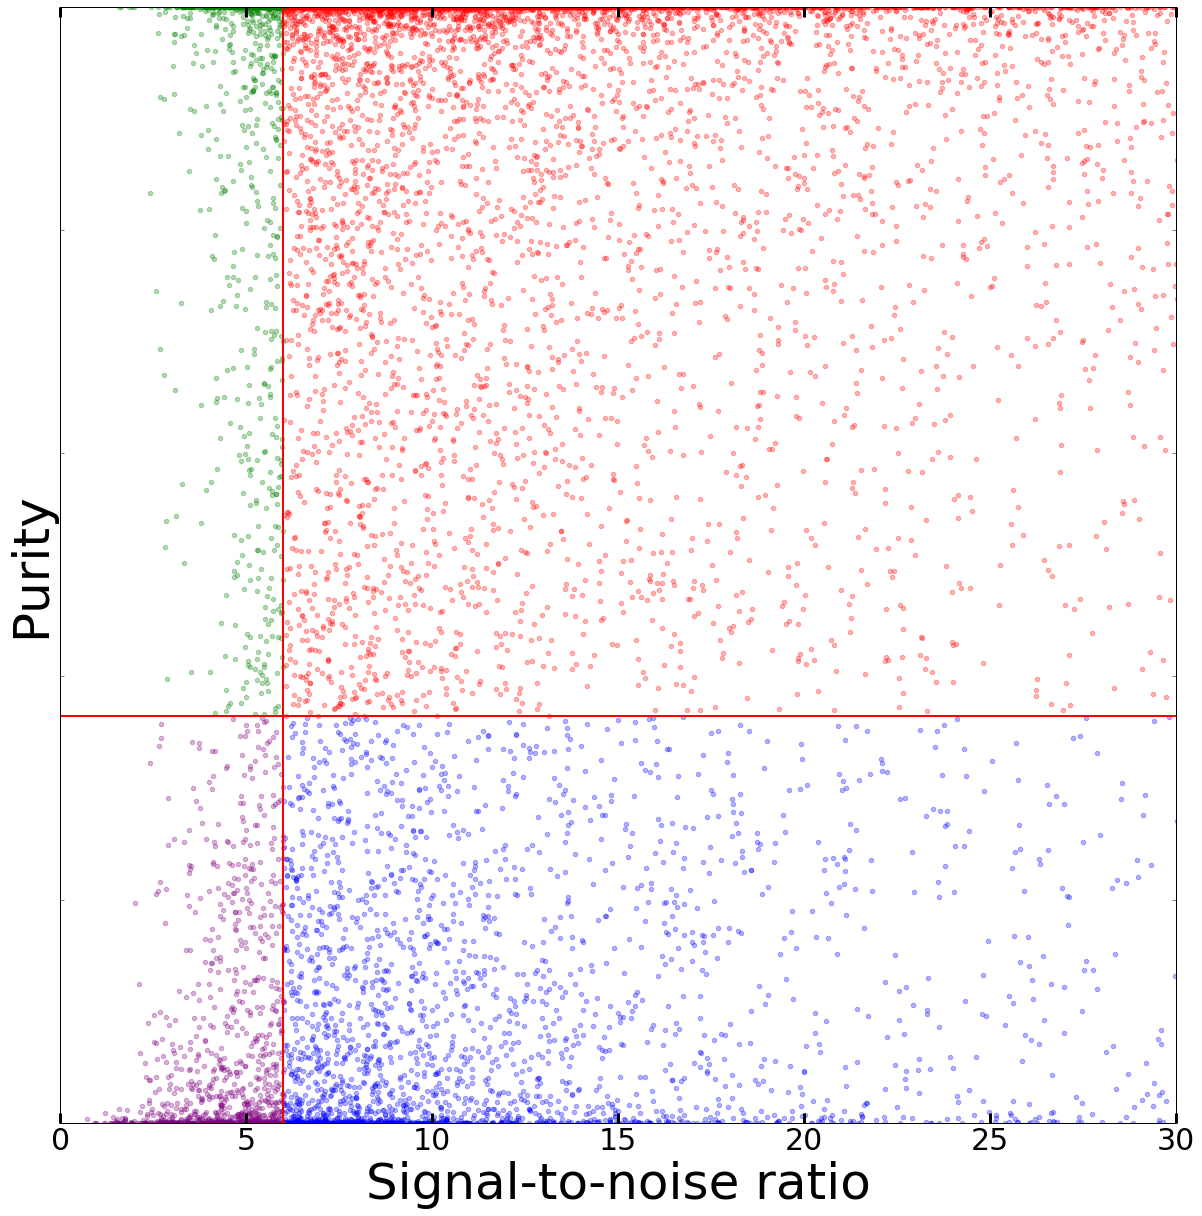

In [48]:
fig = plt.figure(figsize=(20,20))
nrow,ncol = 1,2
power = 50. 

name = 'Not ambiguously blended and detected galaxies'
#'Detected and not ambiguously blended galaxies'
# cats =[cat, detc_and_notambig(cat)]
colors= ['red', 'green', 'blue', 'purple']

# for i,(cat_temp,name) in enumerate(zip(cats,names)):
#     plt.subplot(nrow, ncol, i+1)
# #     if name == 'Not detected and ambiguously blended galaxies':
# #         plt.axhline(.98,color='red',linewidth=2)
# #         purity_snr_scatter_poster(name,cat_temp,colors,cat,1.)
# #     else:
plt.axhline(.98**power,color='red',linewidth=2)
purity_snr_scatter_poster(name,best(cat),colors,power)


plt.axvline(6,color='red',linewidth=2)
plt.xlim(0,30)
fig.savefig('/Users/Ismael/Desktop/scatter_2.pdf')

In [ ]:
import plotly.plotly as py
import plotly.tools as tls
tls.set_credentials_file(username='imendoza', api_key='ffm0hex207')

In [3]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF 

data_matrix = [['Country', 'Year', 'Population'],
               ['United States', 2000, 282200000],
               ['Canada', 2000, 27790000],
               ['United States', 2005, 295500000],
               ['Canada', 2005, 32310000],
               ['United States', 2010, 309000000],
               ['Canada', 2010, 34000000]]

table = FF.create_table(data_matrix)
py.iplot(table, filename='simple_table')



High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~imendoza/0 or inside your plot.ly account where it is named 'simple_table'
